In [33]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score, roc_curve, auc,  precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import string
from mlxtend.data import iris_data
from mlxtend.evaluate import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import string
import seaborn as sns
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz//Dropbox/UCDavis/2016spring/STA208/Github/Data')

In [34]:
SOM = pd.read_pickle('stackoverflow_metric_df.pickle')
RM = pd.read_pickle('Readability_Metrics_wtbody.pickle')
PM = pd.read_pickle('popularity_metric.pickle')
tag_rank=pd.read_pickle('tag_rank.pickle')

In [35]:
query = "SELECT * FROM [posts]"
conn = sqlite3.connect('crossvalidated.db')
post_df = pd.read_sql_query(query, conn)
post_df.head()
qpost_df = post_df[post_df.PostTypeId == 1]

In [36]:
data_SOQ_rna=pd.read_pickle('data_SOQ_rna_binary1.pickle')

In [37]:
Predictors =[u'BodyLen',
 u'LowerCasePer',
 u'UpperCasePer',
 u'SpaceCnt',
 u'TagCnt',
 u'Sentimental_Polarity',
 u'Sentimental_Subjectivity',
 u'TitleLen',
 u'UrlCnt',
 u'formula',
 u'Imagine',
 u'word_count',
 u'sentence_count',
 u'ARI',
 u'CLI',
 u'FKG',
 u'FRE',
 u'GFI',
 u'M_Entropy',
 u'LOC_Per',
 'tag_rank',
 'AccpAnsCnt',
 'AppEditCnt',
 'BadgeCnt',
 'CloDelVCnt',
 'UpVoteCnt',
 'DownVoteCnt',
 'FavVoteCnt']

In [38]:
data_SOQ_rna.shape, data_SOQ_rna.dtypes

((75067, 33), Id                             int64
 BodyLen                        int64
 LowerCasePer                 float64
 UpperCasePer                 float64
 SpaceCnt                       int64
 TagCnt                         int64
 Sentimental_Polarity         float64
 Sentimental_Subjectivity     float64
 TitleLen                       int64
 UrlCnt                         int64
 Code number                    int64
 formula                        int64
 Imagine                        int64
 word_count                     int64
 sentence_count                 int64
 ARI                          float64
 CLI                          float64
 FKG                          float64
 FRE                          float64
 GFI                          float64
 M_Entropy                    float64
 LOC_Per                      float64
 tag_rank                       int64
 AccpAnsCnt                     int64
 AppEditCnt                     int64
 BadgeCnt                       int64

In [39]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_SOQ_rna[Predictors], data_SOQ_rna['Class'], test_size=0.3,random_state=1,stratify=data_SOQ_rna['Class'])

In [40]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((52546, 28), (22521, 28), (52546,), (22521,))

In [41]:
train_y.value_counts(),  test_y.value_counts()

(1    34488
 0    18058
 Name: Class, dtype: int64, 1    14781
 0     7740
 Name: Class, dtype: int64)

## Model Stacking

In [42]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner
from brew.generation import Bagging
#from brew.selection.dynamic import OLA, LCA,APriori, APosteriori, KNORA_UNION, KNORA_ELIMINATE

In [43]:
# Initializing Classifiers
clf2 = RandomForestClassifier(n_estimators=1000,random_state=1,oob_score = True)
clf4 = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=119, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

# Model Ensemble

In [44]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble classifier for scikit-learn estimators.

    Parameters
    ----------

    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.

    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        """
        Fit the scikit-learn estimators.

        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels

        """
        for clf in self.clfs:
            clf.fit(X, y)

    def predict(self, X):
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule

        """

        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)

        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])

        return maj

    def predict_proba(self, X):

        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.

        """
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg

In [45]:
# Creating Ensemble
#ensemble = Ensemble([clf2,clf4])#clf1,clf2, clf3,clf4
#eclf =VotingClassifier(estimators=[('rf', clf2), ('xgboost', clf4)], voting='soft')
np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf2, clf4], weights=[2,5])

In [46]:
eclf.fit(train_x,train_y)
print metrics.accuracy_score(test_y, eclf.predict(test_x)),
print('ROC: %f' % (metrics.roc_auc_score(test_y, eclf.predict(test_x))))
pd.crosstab(test_y, eclf.predict(test_x), rownames=['actual'], colnames=['preds'])

0.665823009635 ROC: 0.539550


preds,0,1
actual,,
0,1050,6690
1,836,13945


In [47]:
np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf2, clf4], weights=[5,8])
eclf.fit(train_x,train_y)
print metrics.accuracy_score(test_y, eclf.predict(test_x)),
print('ROC: %f' % (metrics.roc_auc_score(test_y, eclf.predict(test_x))))
pd.crosstab(test_y, eclf.predict(test_x), rownames=['actual'], colnames=['preds'])

0.666400248657 ROC: 0.540113


preds,0,1
actual,,
0,1054,6686
1,827,13954


In [ ]:
df = pd.DataFrame(columns=('w1', 'w2', 'mean', 'std'))

i = 0
for w1 in range(1,10):
    for w2 in range(1,10):

            if len(set((w1,w2))) == 1: # skip if all weights are equal
                continue

            eclf = EnsembleClassifier(clfs=[clf2, clf4], weights=[w1,w2])
            scores = cross_validation.cross_val_score(
                                            estimator=eclf,
                                            X=train_x,
                                            y=train_y,
                                            cv=5,
                                            scoring='accuracy',
                                            n_jobs=-1)

            df.loc[i] = [w1, w2, scores.mean(), scores.std()]
            i += 1

df.sort(columns=['mean', 'std'], ascending=False)

In [136]:
# Creating Stacking
layer_1 = Ensemble([clf2, clf4])
layer_2 = Ensemble([sklearn.clone(clf2)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)

sclf.fit(train_x,train_y)
print metrics.accuracy_score(test_y, sclf.predict(test_x)),
print('ROC: %f' % (metrics.roc_auc_score(test_y, sclf.predict(test_x))))
pd.crosstab(test_y, sclf.predict(test_x), rownames=['actual'], colnames=['preds'])

ValueError: X must be a 2D array

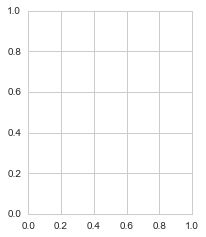

In [116]:
clf_list = [clf2, clf4, eclf]
lbl_list = ['Random Forest', 'xgboost', 'Ensemble', 'Stacking']
# Plotting Decision Regions
gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(10, 8))

itt = itertools.product([0, 1, 2], repeat=2)

for clf, lab, grd in zip(clf_list, lbl_list, itt):
    clf.fit(train_x, train_y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=train_x, y=train_y, clf=clf, legend=2)
    plt.title(lab)
plt.show()